<hr style="border:1px solid #808080">                                                                                                                   </hr>
<h1 style="color:#0176DE;text-align:center;margin:0;padding-top:0;"> <b>Ayudantía 9 - Métodos estadísticos en Python</b>                                                                           </h1>
<h1 style="color:#0176DE;text-align:center;margin:0;padding-top:0;"> <b>IBM/ICE2020 Introducción a la Biomecánica</b>                                                                           </h1>
<p style=padding:0;margin:0>
<h3 style="color:#c1ccdb;text-align:center;margin:0;padding:0;"> Profesor - <span style="color:#dbdbdb;text-align:center;"><b>Daniel Hurtado</b></span></h3>
<h3 style="color:#c1ccdb;text-align:center;margin:0;padding:0;">Ayudantes - <span style="color:#dbdbdb;text-align:center;"><b>Bastián Herrera, Victoria Alfaro, Jorge Villagra</b></span>                               </h3> 
</p>
<h4 style="color:#dbdbdb;text-align:center;margin:0;padding:0;">Instituto de Ingeniería Biológica y Médica<br>Escuela de Ingeniería<br>  Pontificia Universidad Católica de Chile <br>    </h4>
<hr style="border:1px solid #808080">  

Importamos las librerías necesarias para el análisis de datos.

In [32]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as sig
import seaborn as sns
import pickle as pkl
import pandas as pd
import statsmodels.api as sm
import csv

try: data = pd.read_pickle('./tissue-mech.pkl') 
except:
    print('Error in loading data')

El archivo ```tissue-mech.pkl``` corresponde a datos de un ensayo uniaxial de tejido pulmonar de ratas, con una fase armónica a distintas frecuencias. El tejido fue sometido a una misma dosis de elastasa. Preprocesamos el ```pandas.DataFrame``` que contiene el archivo pickle.

In [33]:
a = data['Block'] != 'B1'
df = data[a]
df = df.reset_index()

Aislamos 3 ciclos armónicos para dos frecuencias distintas: 1 Hz y 0.5 Hz.

In [34]:
ids = [1,4,5]

_1hz_stretches = [df["1hz_stretch"][i] for i in ids]
_1hz_stresses  = [df["1hz_stress"][i] for i in ids]

_5hz_stretches = [df[".5hz_stretch"][i] for i in ids]
_5hz_stresses  = [df[".5hz_stress"][i] for i in ids]

Graficamos los datos como una nube de puntos.

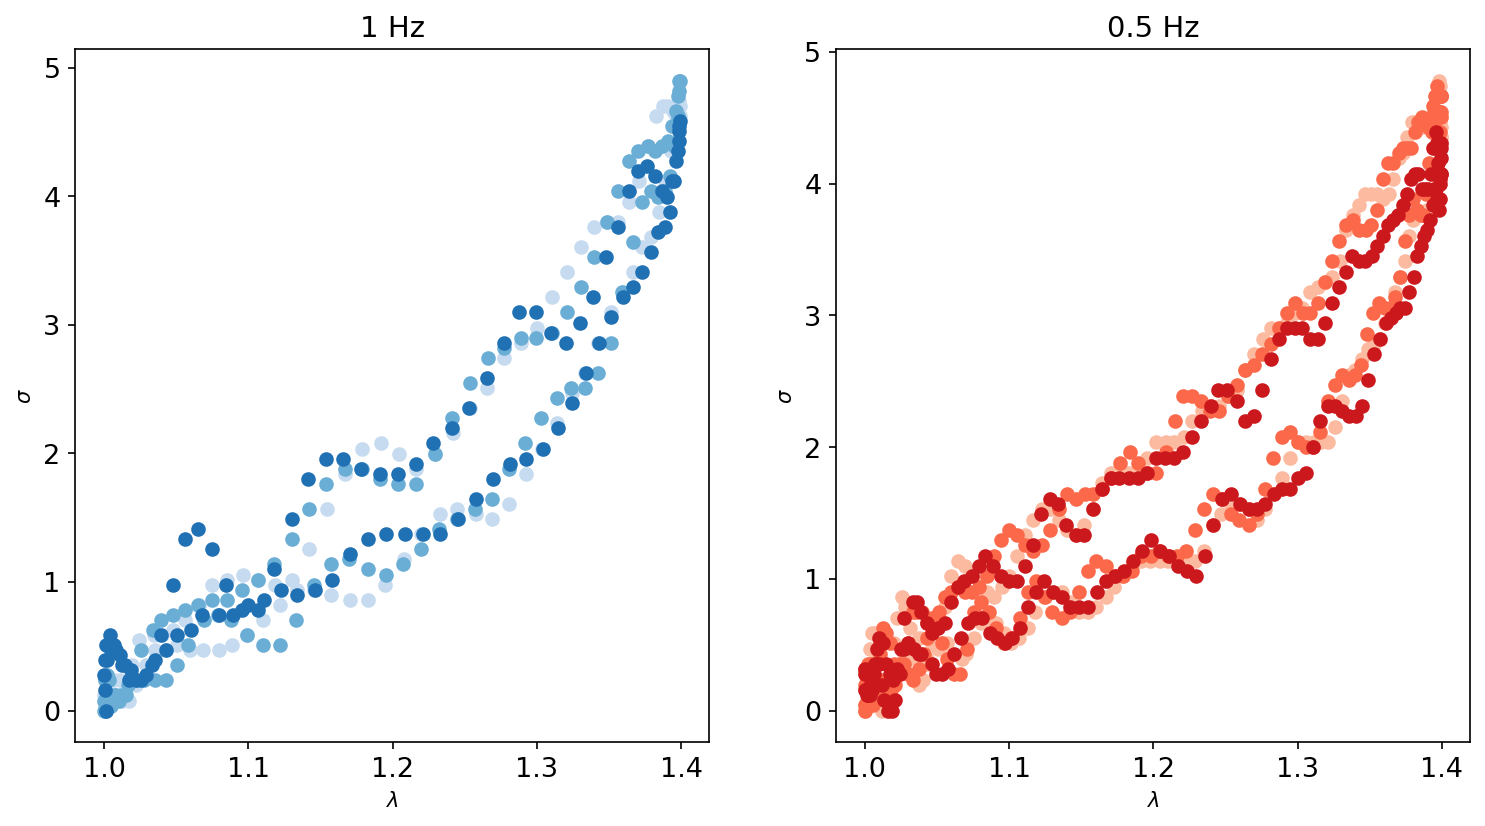

In [35]:
fig, ax = plt.subplots(1,2, figsize=(12,6), dpi=150)

cmap1 = sns.color_palette("Blues", len(ids))
cmap5 = sns.color_palette("Reds", len(ids))

for i in range(len(ids)):
    ax[0].scatter(_1hz_stretches[i], _1hz_stresses[i], color=cmap1[i])
    ax[0].set_xlabel(r"$\lambda$")
    ax[0].set_ylabel(r"$\sigma$")
    ax[0].set_title("1 Hz", fontsize=14)
    ax[1].scatter(_5hz_stretches[i], _5hz_stresses[i], color=cmap5[i])
    ax[1].set_xlabel(r"$\lambda$")
    ax[1].set_ylabel(r"$\sigma$")
    ax[1].set_title("0.5 Hz", fontsize=14)

ax[0].tick_params("both", labelsize=13)
ax[1].tick_params("both", labelsize=13)

plt.show()

Definimos un filtrado pasabajos usando un filtro Butterworth del mismo tipo que tenían que implementar para la Tarea 4. Importante: esto no es una regresión no lineal, puesto que no estamos minimizando una suma de cuadrados (errores) con un modelo paramétrico, como lo sería un modelo hiperelástico. Lo que haremos es utilizar la curva filtrada como si fuese una curva ajustada (de nuevo, no lo es!), y estudiar cómo son los errores entre la curva ajustada y la filtrada, tal como si fueran los residuos de un ajuste no lineal.

In [36]:
def butter_lowpass_filter(data, frac, order=1):
    b, a = sig.butter(order, Wn = frac*50, fs=100, btype='lowpass', analog=False)
    y = sig.filtfilt(b, a, data)
    return y

Graficamos los datos de las fuerzas para ambas frecuencias, donde notamos que hay componentes de muy alta frecuencia que no se relacionan con la respuesta mecánica del tejido.

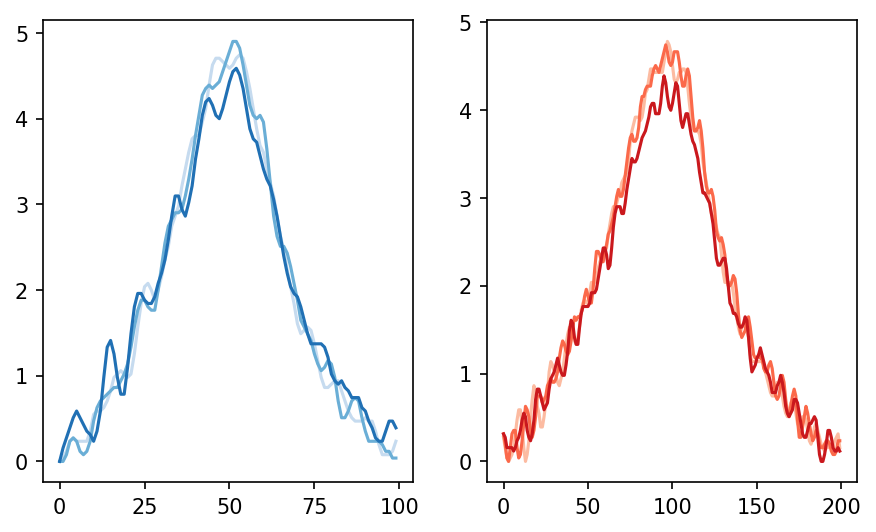

In [37]:
fig, ax = plt.subplots(1,2,figsize=(7,4), dpi=150)

for i in range(len(ids)):
    ax[0].plot(np.arange(*_1hz_stresses[i].shape), _1hz_stresses[i], color=cmap1[i])
    ax[1].plot(np.arange(*_5hz_stresses[i].shape), _5hz_stresses[i], color=cmap5[i])

plt.show()

Hacemos el ajuste y mostramos ambas curvas con sus nubes de puntos.

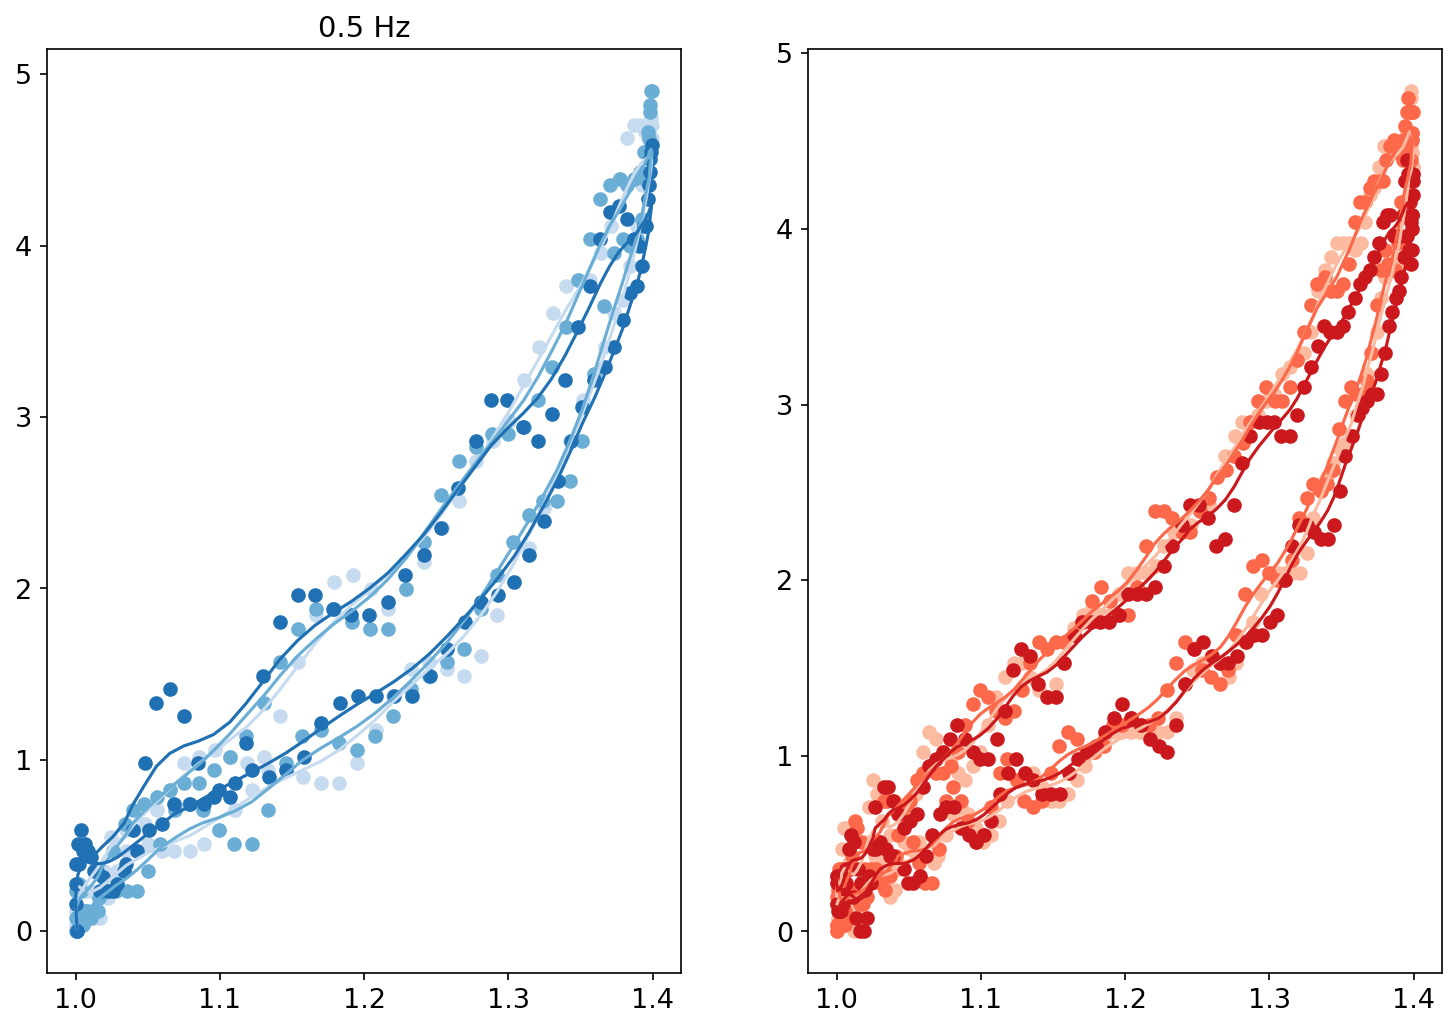

In [38]:
fig, ax = plt.subplots(1,2, figsize=(12,8), dpi=150)

cmap1 = sns.color_palette("Blues", len(ids))
cmap5 = sns.color_palette("Reds", len(ids))

w = 0.10

for i in range(len(ids)):
    ax[0].scatter(_1hz_stretches[i], _1hz_stresses[i], color=cmap1[i])
    ax[0].plot(_1hz_stretches[i], butter_lowpass_filter(_1hz_stresses[i], w), color=cmap1[i])
    ax[0].set_title("1 Hz", fontsize=14)
    ax[1].scatter(_5hz_stretches[i], _5hz_stresses[i], color=cmap5[i])
    ax[1].plot(_5hz_stretches[i], butter_lowpass_filter(_5hz_stresses[i], w), color=cmap5[i])
    ax[0].set_title("0.5 Hz", fontsize=14)

ax[0].tick_params("both", labelsize=13)
ax[1].tick_params("both", labelsize=13)

plt.show()

Examinemos ahora los residuos entre las tensiones observadas $\sigma_i$ y las tensiones "ajustadas" $\hat{\sigma}_i$ (en este caso, filtradas). Al hacer un ajuste, esperaríamos que los residuos $e_i = \sigma_i - \hat{\sigma}_i$ no sigan un patrón definido, sino un comportamiento aleatorio, que usualmente asumimos como proveniente de una distribución normal estándar. Es decir, esperamos que

$$e_i \sim N(0,\sigma^2),$$

para alguna varianza $\sigma^2$ que es constante para todos los residuos. Si la varianza no fuera constante y los residuos fueran, por ejemplo, cada vez más grandes, entonces nuestro modelo no está capturando correctamente las tensiones observadas. En general, cualquier patrón en los residuos es indicador de una mala calidad de ajuste. Así, debemos someter nuestros residuos a **tests de normalidad** para validar esta hipótesis.

Observemos ahora cómo distribuyen los residuos. Calculamos el residuo de nuestra aproximación para cada uno de los datos, y los graficamos.

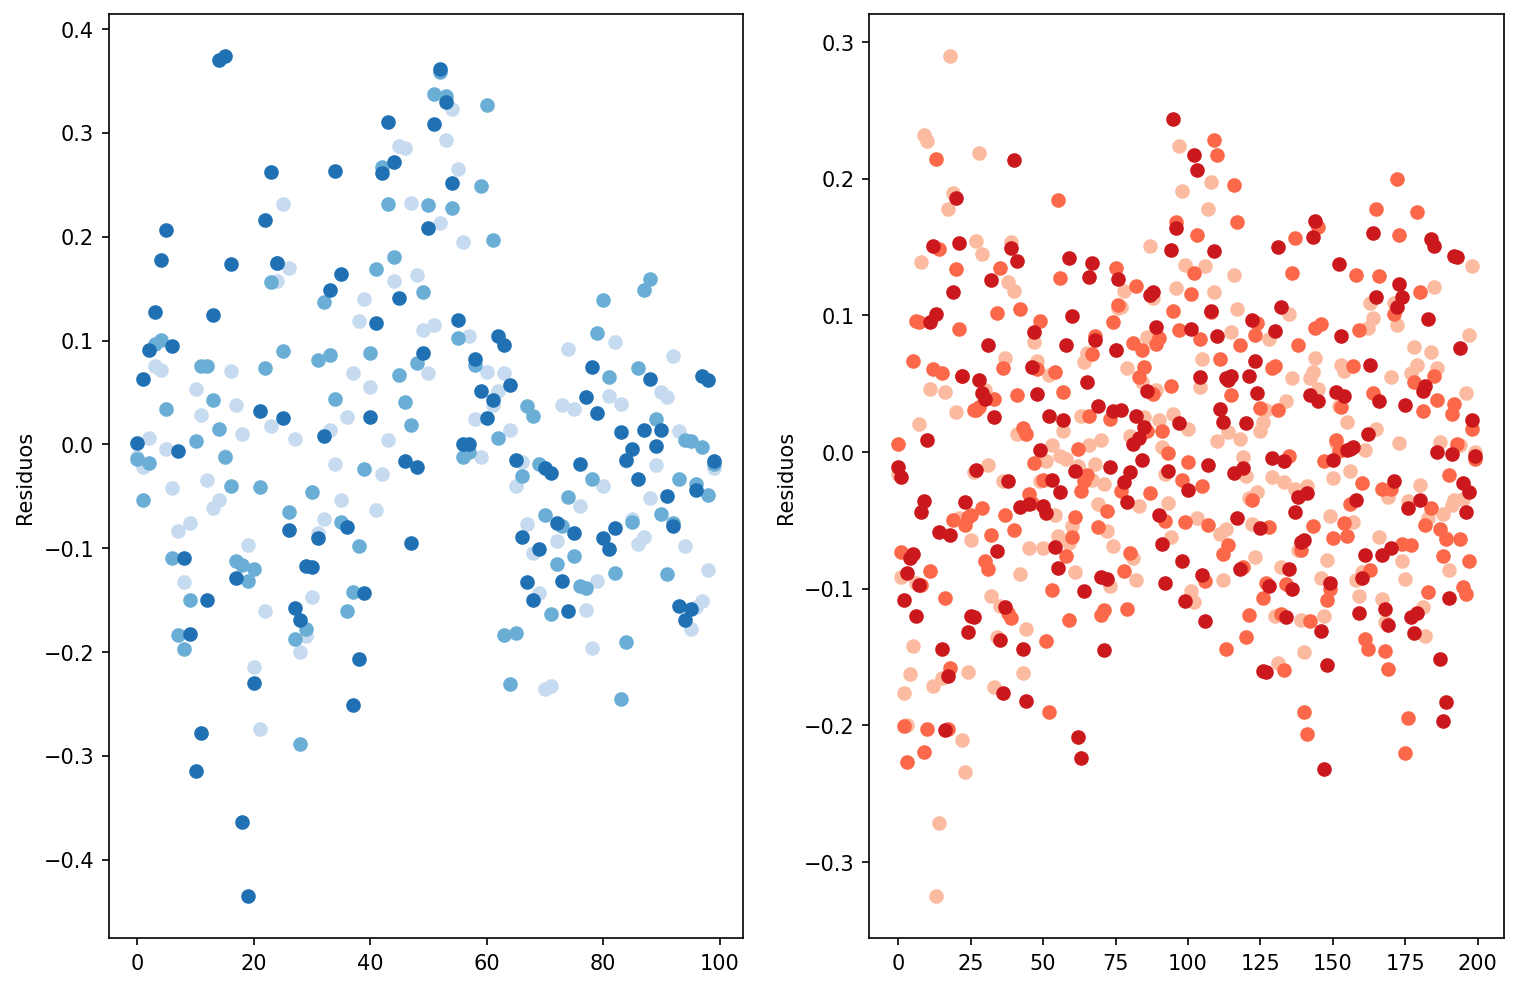

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(12,8), dpi=150)

w = 0.10

resid_1hz = [_1hz_stresses[i] - butter_lowpass_filter(_1hz_stresses[i], w) for i in range(len(ids))]
resid_5hz = [_5hz_stresses[i] - butter_lowpass_filter(_5hz_stresses[i], w) for i in range(len(ids))]

for i in range(len(ids)):
    ax[0].scatter(np.arange(*resid_1hz[i].shape), resid_1hz[i], color=cmap1[i])
    ax[0].set_ylabel("Residuos")
    ax[1].scatter(np.arange(*resid_5hz[i].shape), resid_5hz[i], color=cmap5[i])
    ax[1].set_ylabel("Residuos")

plt.show()

Para poder comparar residuos y hacer tests de normalidad, es necesario estandarizarlos para compararlos con una distribución normal $N(0,1)$, puesto que los datos pueden tener fluctuaciones en cualquier escala $\sigma^2$ (aquí, la varianza es poblacional). Así, definimos los residuos **estandarizados** $r_i$, $i=1,...,N$, como

$$r_i = \frac{e_i}{\hat{\sigma}\sqrt{1-h_{ii}}},$$

donde $\hat{\sigma}$ es la raíz de la varianza muestral, y donde definimos el término de **palanca**

$$ h_ii = \frac{1}{N} + \frac{(x_i - \bar{x})^2}{\sum_j (x_j - \bar{x})^2} $$

que captura qué tan lejana es la variable independiente $x_i$ del promedio $\bar{x}$ para ese residuo. Así, términos con $x_i$ muy alejado de la media tendrán valores de palanca muy grandes, por lo que $r_i$ también será mayor. Esto se puede interpretar como una penalización de las observaciones extremas.

In [40]:
def leverage(residuals, point):
    Sxx = np.sum((residuals-np.mean(residuals))**2)
    # print(f"sxx = {Sxx}")
    return 1/len(residuals) + (point - np.mean(residuals))**2/Sxx

def Standardize(residuals):
    residuals = np.array(residuals)
    obs_std = np.sqrt((1/(len(residuals)-2)) * np.sum(residuals**2))
    # print(f"std = {obs_std}")
    for i in range(residuals.shape[0]):
        palanca = leverage(residuals,residuals[i])
        # print(f"palanca = {palanca}")
        residuals[i] = residuals[i]/(obs_std * np.sqrt(1-palanca))
    return residuals

Veamos que efectivamente nuestros residuos no están estandarizados. Los comparamos con muestras de una distribución normal N(0,1), generada mediante ````np.random.normal(mean, std, shape)```:

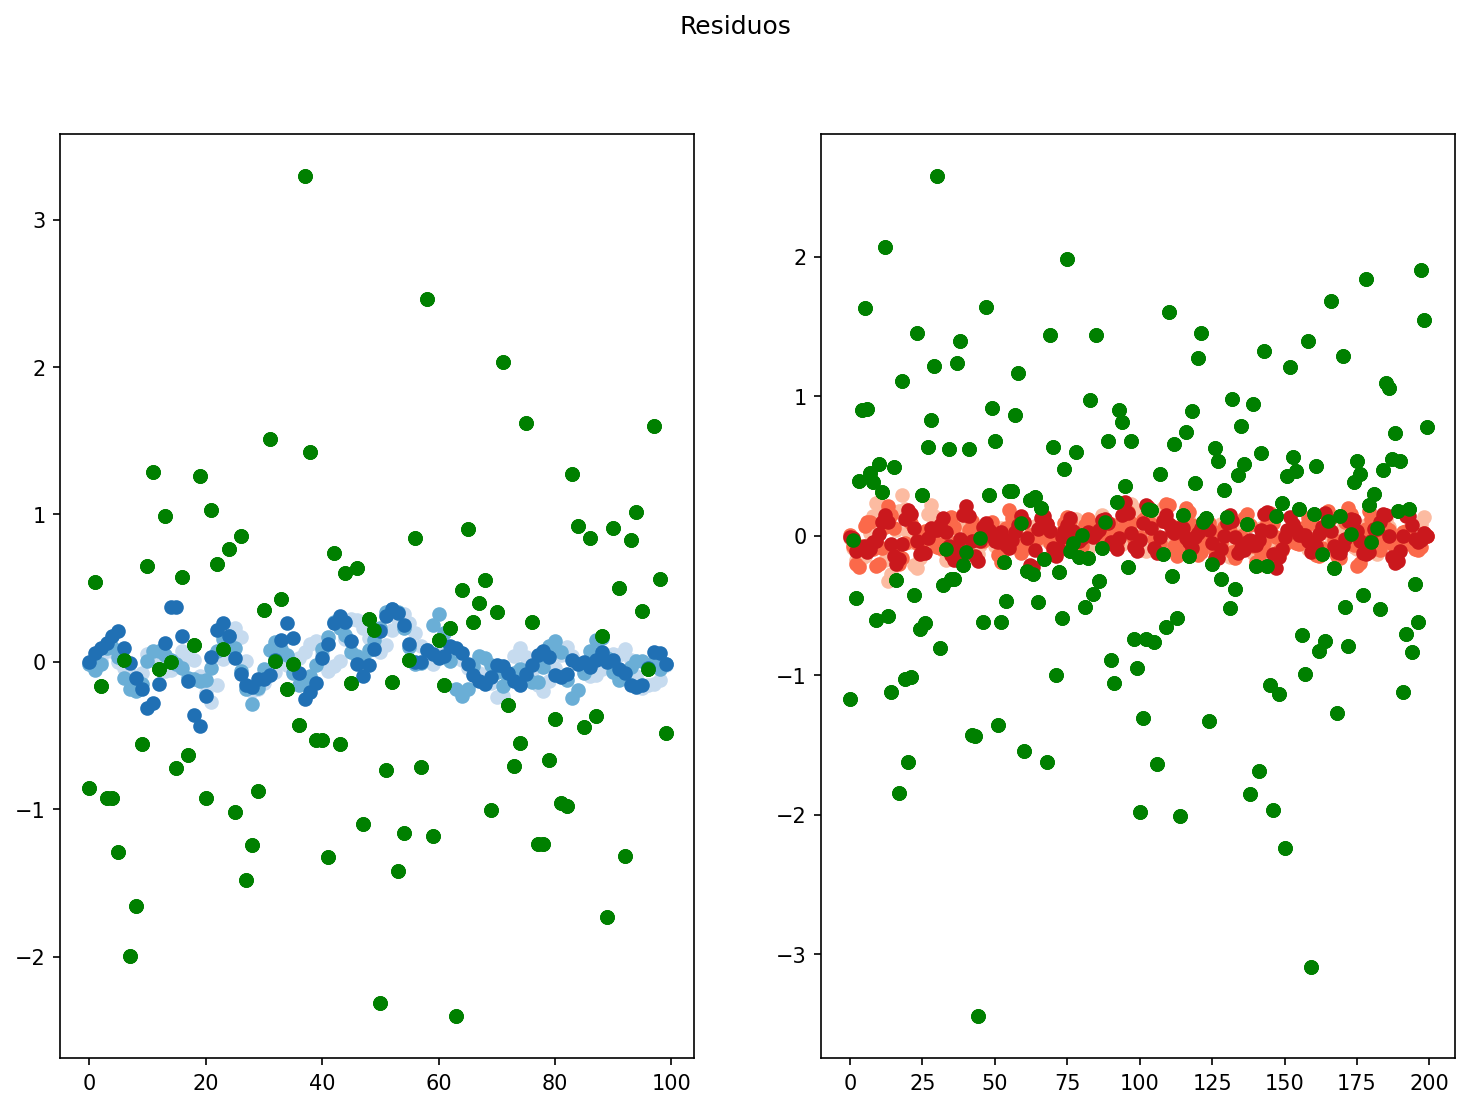

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(12,8), dpi=150)

w = 0.10

resid_1hz = [_1hz_stresses[i] - butter_lowpass_filter(_1hz_stresses[i], w) for i in range(len(ids))]
resid_5hz = [_5hz_stresses[i] - butter_lowpass_filter(_5hz_stresses[i], w) for i in range(len(ids))]
control1 = np.random.normal(0,1,100)
control2 = np.random.normal(0,1,200)

for i in range(len(ids)):
    ax[0].scatter(np.arange(*resid_1hz[i].shape), resid_1hz[i], color=cmap1[i])
    ax[1].scatter(np.arange(*resid_5hz[i].shape), resid_5hz[i], color=cmap5[i])
    ax[0].scatter(np.arange(*control1.shape), control1, color='green')
    ax[1].scatter(np.arange(*control2.shape), control2,  color='green')

fig.suptitle("Residuos")
plt.show()

Así, estandarizamos...

In [42]:
standardized_resid_1hz = []
standardized_resid_5hz = []

for i in range(len(ids)):
    standardized_resid_1hz.append(Standardize(resid_1hz[i]))
    standardized_resid_5hz.append(Standardize(resid_5hz[i]))

... y graficamos nuevamente comparando con datos provenientes de una normal estándar.

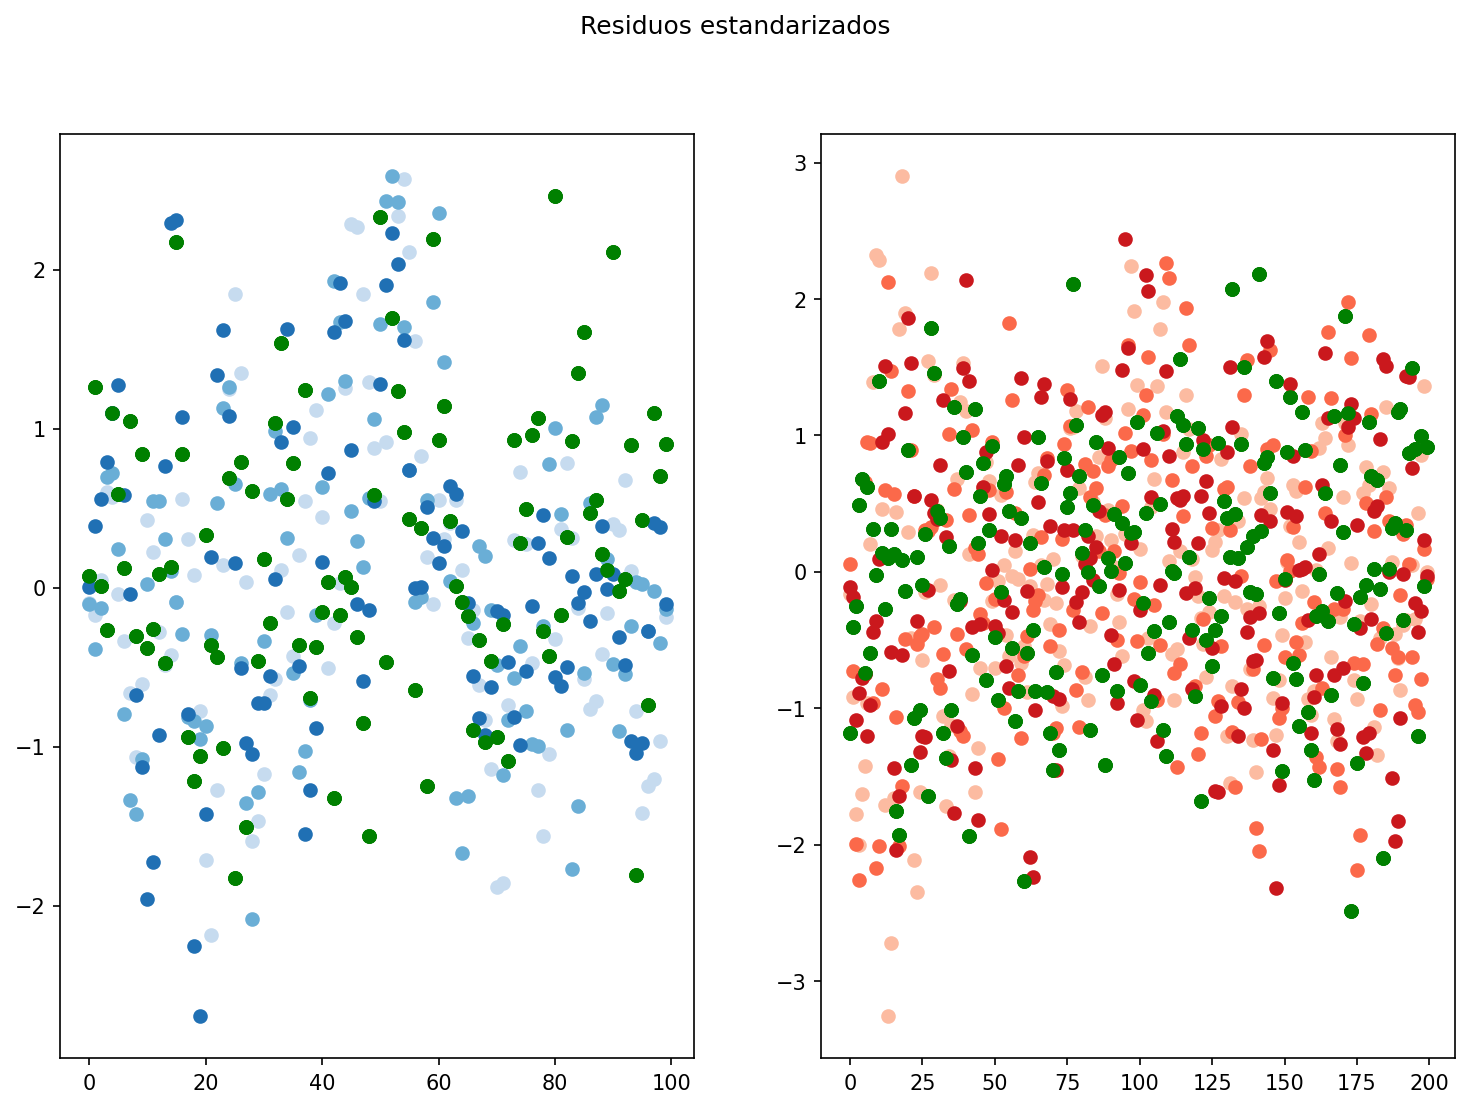

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(12,8), dpi=150)

control1 = np.random.normal(0,1,100)
control2 = np.random.normal(0,1,200)


for i in range(len(ids)):
    ax[0].scatter(np.arange(*standardized_resid_1hz[i].shape), standardized_resid_1hz[i], color=cmap1[i])
    ax[1].scatter(np.arange(*standardized_resid_5hz[i].shape), standardized_resid_5hz[i], color=cmap5[i])
    ax[0].scatter(np.arange(*control1.shape), control1, color='green')
    ax[1].scatter(np.arange(*control2.shape), control2, color='green')

fig.suptitle("Residuos estandarizados")

plt.show()

El primer test de normalidad es cualitativo, y lo haremos mediante un **Q-Q plot**. En este gráfico, comparamos los cuantiles de una función acumulativa sobre los residuos. Si los datos provienen de una distribución $N(0,1)$, esperamos que los cuantiles estén sobre la línea $y=x$ (en rojo). Probamos el funcionamiento del test, que realizamos mediante ```statsmodels.api.qqplot```, usando como input datos que sí son provenientes de una normal estándar.

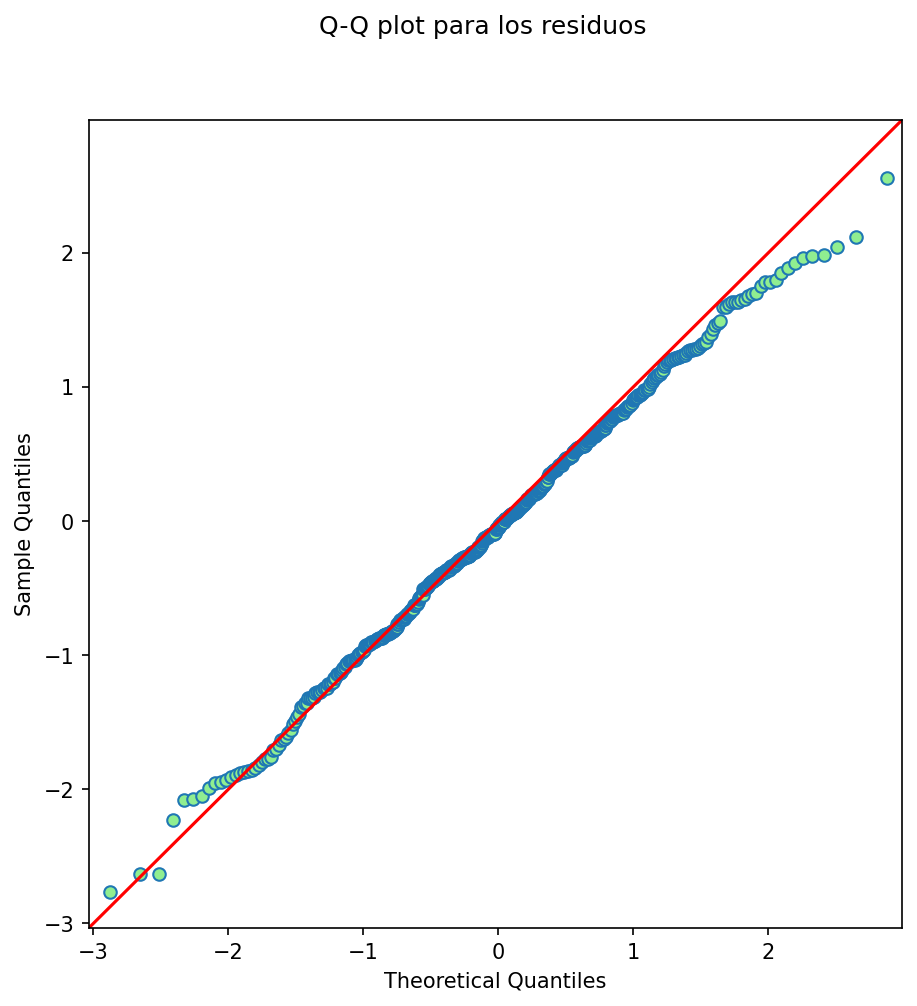

In [44]:
fig, ax = plt.subplots(figsize=(7,7), dpi=150)

normals = np.random.normal(0,1,500)

sm.qqplot(normals, line="45", ax=ax, markerfacecolor= "lightgreen")

fig.suptitle("Q-Q plot para los residuos")

plt.show()

Observamos que hay muy buena concordancia entre los cuantiles observados y los esperados, ya que se encuentran sobre la línea roja. Repetimos este análisis para los residuos de ambos experimentos:

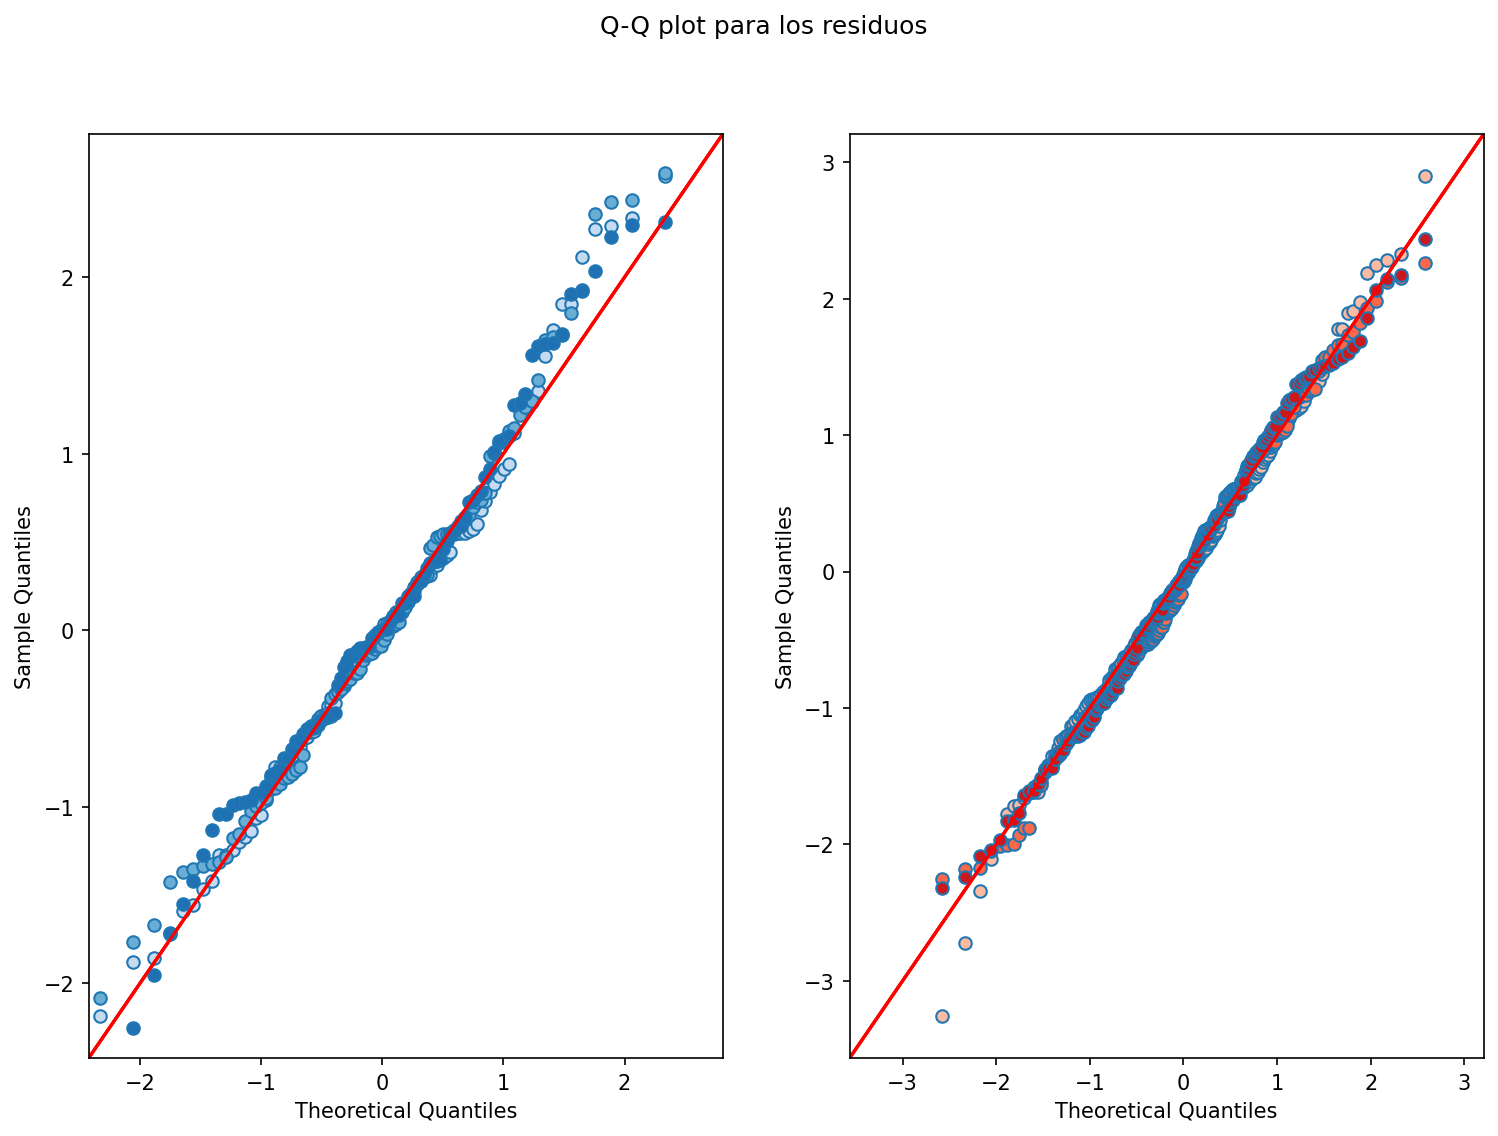

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(12,8), dpi=150)

normals = np.random.normal(0,1,100)

for i in range(len(ids)):
    sm.qqplot(standardized_resid_1hz[i], line="45", ax=ax[0], markerfacecolor= cmap1[i])
    sm.qqplot(standardized_resid_5hz[i], line="45", ax=ax[1],markerfacecolor= cmap5[i])

# sm.qqplot(normals, line="45", ax=ax[0], markerfacecolor= "lightgreen")

fig.suptitle("Q-Q plot para los residuos")

plt.show()

Vemos que también hay una muy buena concordancia de los residuos con lo que esperamos de una distribución normal estándar. Esto es esperable, puesto que el paso de filtrado que usamos en vez de hacer un ajuste no lineal elimina los componentes de alta frecuencia, pero sabemos que estos componentes multiplican (en el dominio de Fourier) funciones seno o coseno, que independiente de la frecuencia, tienen media $0$.

El segundo test de normalidad es cuantitativo, y consiste en el test de **Shapiro-Wilk**. En este test definimos un estadístico SW, que toma valores entre $0$ y $1$. Planteamos el test de hipótesis sobre los residuos con la hipótesis nula

$$H_0: r_i \sim N(0,1),$$

y la hipótesis alternativa

$$H_1: r_i \not\sim N(0,1).$$

El test de Shapiro-Wilk rechaza $H_0$ cuando $SW$ es muy pequeño, cercano a $0$. En caso contrario, no hay evidencia para rechazar $H_0$, por lo que esperamos que los datos sí provengan de una distribución normal estándar. Equivalentemente, para un nivel de confianza $\alpha$, esperamos que si el valor-p del test es menor que $\alpha$, entonces hay evidencia de no-normalidad de los datos, y en caso contrario no hay evidencia de no-normalidad.

Convenientemente, el test de Shapiro-Wilk se puede llevar a cabo en una línea de código, usando la función ```scipy.stats.shapiro```. Fijemos $\alpha=0.05$ y probemos el test para datos provenientes de una distribución normal. 

In [46]:
SW_control, SW_control_pvalue = stats.shapiro(normals)
print(f"Estadístico de Shapiro-Wilk (grupo control) SW = {SW_control}")
print(f"Valor-p del test de Shapiro-Wilk (grupo control) p = {SW_control_pvalue}")

Estadístico de Shapiro-Wilk (grupo control) SW = 0.9891852140426636
Valor-p del test de Shapiro-Wilk (grupo control) p = 0.5991954207420349


Así, vemos que $p>>0.05$, por lo que no hay evidencia para rechazar $H_0$, y luego los datos provienen de una distribución normal con una confianza $\alpha$. Probamos ahora para nuestros residuos, para cada ensayo por separado:

In [47]:
for i in range(len(ids)):
    print(f"Test de Shapiro-Wilk, grupo 1 Hz, muestra {i+1}")
    SW_1, SW_1_pvalue = stats.shapiro(resid_1hz[i])
    print(f"SW = {SW_1}")
    print(f"p = {SW_1_pvalue}\n")
    SW_5, SW_5_pvalue = stats.shapiro(resid_5hz[i])
    print(f"Test de Shapiro-Wilk, grupo 0.5 Hz, muestra {i+1}")
    print(f"SW = {SW_5}")
    print(f"p = {SW_5_pvalue}\n")

Test de Shapiro-Wilk, grupo 1 Hz, muestra 1
SW = 0.9837214946746826
p = 0.2559449374675751

Test de Shapiro-Wilk, grupo 0.5 Hz, muestra 1
SW = 0.9971499443054199
p = 0.9754500389099121

Test de Shapiro-Wilk, grupo 1 Hz, muestra 2
SW = 0.9810778498649597
p = 0.1611531376838684

Test de Shapiro-Wilk, grupo 0.5 Hz, muestra 2
SW = 0.9886257648468018
p = 0.11186561733484268

Test de Shapiro-Wilk, grupo 1 Hz, muestra 3
SW = 0.9867236614227295
p = 0.4193130135536194

Test de Shapiro-Wilk, grupo 0.5 Hz, muestra 3
SW = 0.9909827709197998
p = 0.24749945104122162



En todos los casos tenemos $SW\approx 1$, y solo para la muestra 2 del grupo de $0.5$ Hz tenemos un valor-p relativamente bajo pero que sí permite que para niveles de confianza altos ($\alpha < 0.1$) concluir que los residuos vienen de una distribución normal estándar. Así, podemos concluir que nuestro ajuste no lineal es bueno, en la medida en que probamos que, para un nivel de confianza fijo, los residuos están normalmente distribuidos.